In [0]:
pip install dionysus

In [0]:
%matplotlib inline
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
import torchvision
import torchvision.transforms as T
import torchvision.datasets as dsets
import numpy as np 
import pandas as pd 
import itertools
import math
import time
import matplotlib.pyplot as plt
from __future__ import print_function
import dionysus as d
import csv
from collections import defaultdict
# import sys
# sys.path.append('../Python')
from torch.autograd import Variable, Function
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision.utils import save_image
from pprint import pprint
import os 

In [0]:
transform = T.Compose(
    [T.ToTensor(),
     T.Normalize((0.5), (0.5))])

trainset = torchvision.datasets.MNIST(root='.', 
                                      train=True,
                                      download=True, 
                                      transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=4,
                                          shuffle=True)

testset = torchvision.datasets.MNIST(root='.', 
                                     train=False,
                                     download=True, 
                                     transform=transform)
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=4,
                                         shuffle=False)

classes = [str(i) for i in range(0,10)]
print(classes)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


    1     3     5     8


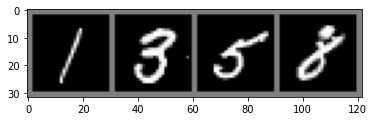

In [0]:


# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        out = self.model(x.view(x.size(0), 784))
        out = out.view(out.size(0), -1)
        return out.cuda()

In [0]:
ape = (1, 28, 28)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, int(np.prod(ape))),
            nn.Tanh()
        )
    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *ape)
        return img

In [0]:
discriminator = Discriminator()
generator = Generator()

if torch.cuda.is_available():
    print("Using CUDA")
    discriminator.cuda()
    generator.cuda()

criterion = nn.BCELoss()
lr = 0.0002
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

Using CUDA


In [0]:
def train_discriminator(discriminator, images, real_labels, fake_images, fake_labels):
    discriminator.zero_grad()
    outputs = discriminator(images)
    real_loss = criterion(outputs, real_labels)
    real_score = outputs
    
    outputs = discriminator(fake_images) 
    fake_loss = criterion(outputs, fake_labels)
    fake_score = outputs

    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss, real_score, fake_score

In [0]:
def train_generator(generator, discriminator_outputs, real_labels):
    generator.zero_grad()
    g_loss = criterion(discriminator_outputs, real_labels)
    g_loss.backward()
    g_optimizer.step()
    return g_loss

In [0]:
num_test_samples = 16
test_noise = Variable(torch.randn(num_test_samples, 100)).cuda()

In [0]:
def Generate_and_Save_Images(model, epoch, test_input):
    predictions = model(test_input).cpu()
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, : , 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [0]:
# create figure for plotting
size_figure_grid = int(math.sqrt(num_test_samples))
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)

# set number of epochs and initialize figure counter
num_epochs = 50
num_batches = len(trainloader)

for epoch in range(num_epochs):
    for n, (images, _) in enumerate(trainloader):
        images = Variable(images).cuda()
        real_labels = Variable(torch.ones(images.size(0))).cuda()
        
        # Sample from generatortrain_discriminator
        noise = Variable(torch.randn(images.size(0), 100)).cuda()

        fake_images = generator(noise)
        fake_labels = Variable(torch.zeros(images.size(0))).cuda()
        
        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(discriminator, images, real_labels, fake_images, fake_labels)
        
        # Sample again from the generator and get output from discriminator
        noise = Variable(torch.randn(images.size(0), 100)).cuda()
        fake_images = generator(noise)
        outputs = discriminator(fake_images)

        # Train the generator
        g_loss = train_generator(generator, outputs, real_labels)

        
        test_images = generator(test_noise)
        if n  % 15000 == 0:
          for k in range(num_test_samples):
              plt.subplot(4, 4, k + 1)
              plt.imshow(test_images[k,:].data.cpu().numpy().reshape(28, 28), cmap='Greys_r')
          plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
          plt.show()
            
        if n % 1000 == 0:
          print(f'Epoch [{epoch+1}/{num_epochs}], step[{n+1}/{num_batches}], Discriminator Loss: {d_loss.item()}, Generator Loss: {g_loss.item()}')
                


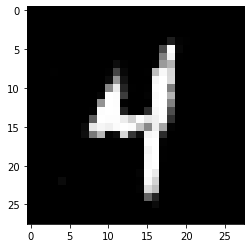

In [0]:
num_test_samples = 16
test_noise_new = Variable(torch.randn(5, 100)).cuda()
with torch.no_grad():
        gen_image = generator(test_noise_new).cpu()
        plt.imshow(gen_image[4,0,:,:], cmap='gray')


In [0]:
#################################################
##############TOP LOSS TRAINER###################
#################################################
torch.save(generator.state_dict(), 'Standard_Gan_EPOCHS_50.pt')

In [0]:

dtype=torch.float32
''' Change to touch.double to try gradient check '''
# dtype=torch.double
PRINT = False

class Diagramlayer(Function):
    def __init__(self):
        super(Diagramlayer, self).__init__()
        # self.p = chopt.Cohomology()
        # self.p.readIn(triangulation_file)
        # self.p.init()

    def init_filtration(self, faces):
        F = faces
        f = d.Filtration()
        for i in range(F.shape[0]):
            if len(F[i]) == 4:
                c = d.closure([d.Simplex([int(F[i][0]), int(F[i][1]), int(F[i][2]), int(F[i][3])], 0.0)], 3) #np.array(0).astype(DTYPE))],2)
            elif len(F[i]) == 3:
                c = d.closure([d.Simplex([int(F[i][0]), int(F[i][1]), int(F[i][2])], 0.0)], 3)
            for j in c:
                f.append(j)
        return f

    # Note that both forward and backward are @staticmethods
    @staticmethod
    # bias is an optional argument
    def forward(ctx, x, F):
        if PRINT: print("*** dgm start")
        start_time = time.time()
        function_values = x
        # list of function values on vertices, and maximal dimension it will return 0,1,2,3
        function_useable = function_values.data.numpy().flatten()

        dgms, Tbl = computePersistence(F, -1.0 * function_useable.reshape(1,-1))
        num_dgm_pts = np.max([len(dgms[0]), len(dgms[1]), len(dgms[2])])
        dgms_inds = -1 * np.ones([3, num_dgm_pts, 2])
        if len(dgms[0]) > 0:
            dgms_inds[0][:len(dgms[0])] = np.array(dgms[0])[:, [2,3]]
        if len(dgms[1]) > 0:
            dgms_inds[1][:len(dgms[1])] = np.array(dgms[1])[:, [2,3]]
        if len(dgms[2]) > 0:
            dgms_inds[2][:len(dgms[2])] = np.array(dgms[2])[:, [2,3]]
        dgms_inds[np.where(dgms_inds == np.inf)] = -1

        vertices_indices = dgms_inds
        corr_function_values = -np.inf * np.ones(vertices_indices.shape)
        dgm = vertices_indices
        for i in range(0, len(dgm)):
            if len(dgm[i]) > 0:
                dgmi = np.unique( np.array(dgm[i]), axis=0 ).astype(np.int)
                corr_f_values = function_useable[dgmi]
                ''' Change to -1.0 for gradient check '''
                corr_f_values[np.where(dgmi == -1)] = -np.inf # -1.0
                corr_function_values[i][:np.min([corr_f_values.shape[0], num_dgm_pts])] = corr_f_values[:np.min([corr_f_values.shape[0], num_dgm_pts])]
                vertices_indices[i][:np.min([len(dgmi), num_dgm_pts])] = dgmi[:np.min([len(dgmi), num_dgm_pts])]

        output = torch.tensor(corr_function_values).type(dtype)
        ctx.save_for_backward(x, torch.tensor(vertices_indices).type(dtype), output)
        if PRINT: print("*** dgm done", time.time() - start_time)
        return output

    # This function has only a single output, so it gets only one gradient
    @staticmethod
    def backward(ctx, grad_output):
        # This is a pattern that is very convenient - at the top of backward
        # unpack saved_tensors and initialize all gradients w.r.t. inputs to
        # None. Thanks to the fact that additional trailing Nones are
        # ignored, the return statement is simple even when the function has
        # optional inputs.
        input, vertices_indices, output = ctx.saved_variables
        grad_input = torch.zeros(input.shape).type(dtype)
        output[output > -np.inf] = 1
        output[output == -np.inf] = 0
        np_vertices_indices = vertices_indices.numpy()
        list_of_unique_indices = np.unique(np_vertices_indices.flatten())
        grad_intermediate = output * grad_output # (dgms, dgm_pts, 2)
        for i in range(len(list_of_unique_indices)):
            index = list_of_unique_indices[i]
            if index > -1:
                index_into_grad_output = np.where(np_vertices_indices == index)
                grad_input[int(index)] = torch.sum( grad_intermediate[index_into_grad_output] )
        return grad_input, None

In [0]:

dtype = torch.float32

''' Example of how to construct a cost function based on the persistence diagrams. '''
def cost_function(dgms):
    ''' Undefined are -1.0 for our rips and infinite are at saturation value '''
    dgm0 = dgms[0].type(dtype).clone()
    min_value = -1.0 # not always true, but can be assumed in most contexts
    dgm0[dgm0 == -np.inf] = min_value
    NAN = torch.tensor(float('nan')).type(dtype)
    lifetimes0 = torch.abs(dgm0[:,1]-dgm0[:,0])
    lifetimes0[lifetimes0 != lifetimes0] = 0
    sorted_d_dgm0, indsD0 = torch.sort( dgm0[:,1][dgm0[:,1] > -np.inf], 0)
    sorted0, inds0 = torch.sort(lifetimes0, 0, descending=True)

    cost = torch.add(
        torch.Tensor([0.0]),
        torch.mul(torch.sum(torch.abs(sorted0[1:1+10000])), 1.0),
        #torch.mul(torch.sum(torch.abs(sorted1[0:0+10000])), 1.0),
    )
    return cost

def top_cost(W, diagramlayer, filtration):
    dgms = diagramlayer(W.view(-1), filtration)
    return cost_function(dgms)

''' Example of how to run the cost over a batch '''
def top_batch_cost(gen_imgs, diagramlayer, filtration):
    start_time = time.time()
    axis=0
    costs = torch.stack([
        top_cost(x_i.view(-1), diagramlayer, filtration) for i, x_i in enumerate(torch.unbind(gen_imgs, dim=axis), 0)
    ], dim=axis)
    avg = torch.mean(costs.view(-1))
    print("top_batch_cost", "time: ", time.time() - start_time, "cost: ", avg)
    return avg
    ''' *** End Topology *** '''

def maxPolys(dgm1):
    b, d = dgm1[:, np.arange(0, dgm1.shape[1]-1,2)], dgm1[:, np.arange(1, dgm1.shape[1],2)]
    lifetimes = torch.abs(b - d)
    sorted, argsmax = torch.sort(lifetimes, dim=1, descending=True)
    #print sorted.shape, argsmax.shape # (64, 27)
    #argsmax = np.argsort(lifetimes)[::-1]
    #p1,p2,p3,p4 = np.sum(lifetimes[argsmax[:1]]),np.sum(lifetimes[argsmax[:2]]),np.sum(lifetimes[argsmax[:3]]),np.sum(lifetimes[argsmax[:4]])
    #print torch.sum(sorted[:,:2], dim=1).shape
    polys = torch.stack([
            torch.unsqueeze(torch.sum(sorted[:,:1], dim=1), dim=1),
            torch.unsqueeze(torch.sum(sorted[:,:2], dim=1), dim=1),
            torch.unsqueeze(torch.sum(sorted[:,:3], dim=1), dim=1),
            torch.unsqueeze(torch.sum(sorted[:,:4], dim=1), dim=1),
        ], dim=1)

    #print polys.shape # (64,4,1)
    polys = polys[:,:,0]
    return polys

def sumPolys(dgm1):
    b, d = dgm1[:, np.arange(0, dgm1.shape[1]-1,2)], dgm1[:, np.arange(1, dgm1.shape[1],2)]
    lifetimes = torch.abs(b - d)
    sorted, argsmax = torch.sort(lifetimes, dim=1, descending=True)
    polys = torch.unsqueeze(torch.sum(sorted, dim=1), dim=1)
    return polys

def top_features(x, diagramlayer, filtration, dim=1):
    # dgmsTop = diagramlayer(x.view(-1), filtration)
    # dgmsTop = dgmsTop.detach().numpy()
    # dgm1 = dgmsTop[1]
    # dgm1 = np.delete(dgm1, np.where((dgm1 == (-np.inf, -np.inf)).all(axis=1)), axis=0)
    # dgm1 = dgm1.flatten()
    #print("top_features", x)
    dgms = diagramlayer(x.view(-1), filtration)
    dgm1 = dgms[dim].type(dtype).clone()
    lifetimes1 = torch.abs(dgm1[:,1]-dgm1[:,0])
    lifetimes1[lifetimes1 != lifetimes1] = 0
    #sorted_d_dgm1, indsD1 = torch.sort( dgm1[:,1][dgm1[:,1] > -np.inf], 0)
    sorted1, inds1 = torch.sort(lifetimes1, 0, descending=True)
    p1, p2, p3, p4 = torch.sum(sorted1[:1]), torch.sum(sorted1[:2]), torch.sum(sorted1[:3]), torch.sum(sorted1[:4])
    #p1, p2, p3, p4 = torch.sum(sorted1[1:2]), torch.sum(sorted1[1:3]), torch.sum(sorted1[1:4]), torch.sum(sorted1[1:10])
    #print p1, p2, p3, p4
    polys = torch.stack([
            torch.unsqueeze(p1, dim=0),
            torch.unsqueeze(p2, dim=0),
            torch.unsqueeze(p3, dim=0),
            torch.unsqueeze(p4, dim=0),
        ], dim=1)
    #print polys
    polys = polys[0]
    return polys

def top_features_01(x, diagramlayer, filtration):
    dgms = diagramlayer(x.view(-1), filtration)
    ''' dim 0 '''
    dgm = dgms[0].type(dtype).clone()
    lifetimes = torch.abs(dgm[:,1]-dgm[:,0])
    lifetimes[lifetimes != lifetimes] = 0
    sorted, inds = torch.sort(lifetimes, 0, descending=True)
    a1, a2, a3, a4 = torch.sum(sorted[1:2]), torch.sum(sorted[1:3]), torch.sum(sorted[1:4]), torch.sum(sorted[1:10])
    ''' dim 1 '''
    dgm = dgms[1].type(dtype).clone()
    lifetimes = torch.abs(dgm[:,1]-dgm[:,0])
    lifetimes[lifetimes != lifetimes] = 0
    sorted, inds = torch.sort(lifetimes, 0, descending=True)
    p1, p2, p3, p4 = torch.sum(sorted[:1]), torch.sum(sorted[:2]), torch.sum(sorted[:3]), torch.sum(sorted[:4])
    polys = torch.stack([
            torch.unsqueeze(a1, dim=0),
            torch.unsqueeze(a2, dim=0),
            torch.unsqueeze(a3, dim=0),
            torch.unsqueeze(a4, dim=0),
            torch.unsqueeze(p1, dim=0),
            torch.unsqueeze(p2, dim=0),
            torch.unsqueeze(p3, dim=0),
            torch.unsqueeze(p4, dim=0),
        ], dim=1)
    #print polys
    polys = polys[0]
    return polys

def top_batch_features(input, diagramlayer, filtration, dim=1):
    #print(gen_imgs.shape)
    start_time = time.time()
    axis=0
    #print("input",input)
    feats = torch.stack([
        top_features(x_i.view(-1), diagramlayer, filtration, dim) for i, x_i in enumerate(torch.unbind(input, dim=axis), 0)
    ], dim=axis)
    #avg = torch.mean(costs.view(-1))
    print("feats", "time: ", time.time() - start_time)
    #print feats.shape
    return feats

In [0]:


# Returns enhanced diagram from a filtration
# dgm - a dictionary indexed by dimension
# Note:
#	if death time is infinite - then the second pairing is meaningless
# 	each dictionarry is a list of 4-tuples
#		(birth time, death time, birth vertex, death vertex)
# Input: m is the output of homology_persistence(f),
#        f is a filtration
#        Tbl is a dictionary from simplex to vertex (depends on the function)
def returndgm(m,f,Tbl):
	dgm = {}
	for i in range(len(m)-1):
		dgm[i] = []
    # Tbl is a dictionary from simplex to vertex (depends on the function) / from simplex to two points (three points cause includes value)
    # b_value_i, d_value_i, b_e_b (or -1), b_e_d (or -1), d_e_b (or -1), d_e_d (or -1)
	#point_index_to_points_indices = defaultdict(lambda: [])
	for i in range(len(m)-1):
		if m.pair(i) < i: continue      # skip negative simplices
		dim = int(f[i].dimension())
		pair = m.pair(i) # now an edge
		if pair != m.unpaired and f[pair].data-f[i].data > 0:
			b_a, d_a = Tbl[i], Tbl[pair] # FROM TABLE!
			dgm[dim].append( [f[i].data, f[pair].data, b_a[0], b_a[1], d_a[0], d_a[1]] )
		elif m.pair(i) == m.unpaired:
			b_a = Tbl[i]
			dgm[dim].append([f[i].data, np.inf, b_a[0], b_a[1], -1, -1])
	return dgm #, point_index_to_points_indices

# currently the fastest update procedure
# takes in a filtration F and a vector fnew of new
# function values defined on the vertices
# TODO: check if we update Tbl is it faster
#       than creating it from scratch each time
''' OBS: Don't think it's working for homology classes of dimension 2 '''
def computePersistenceflag(F):
	# update filtration
	# TODO: F and fnew doesn't have to have the same number of decimals!!!!!
	Tbl = {} # From simplex to attaching edge [a,b,value]
	#round_decimals = 10
	# SETTING IT TO s.data changes the float, must be somthing with the filtration structure
	F.sort() # so we know we are visting lover dimension before higher dimensions
	for s in F:
		index_s = F.index(s)
		if s.dimension() == 0:
			Tbl[index_s] = [-1, -1, 0]
		elif s.dimension() == 1:
			max_edge = [s[0], s[1], s.data]
			Tbl[index_s] = max_edge
		elif s.dimension() == 2: # s is now a triangle
			edges = [F.index(b) for b in s.boundary()]
			edges_data = [F[e].data for e in edges]
			edge_index = np.argmax(np.array([edges_data]))
			attaching = [F[edges[edge_index]][0], F[edges[edge_index]][1], edges_data[edge_index]]
			Tbl[index_s] = attaching
		elif s.dimension() == 3: # s is now a tetrahedron
			edges_triples = [Tbl[F.index(b)] for b in s.boundary()]
			edges_data = [e[2] for e in edges_triples]
			edge_index = np.argmax(np.array([edges_data]))
			attaching = edges_triples[edge_index]
			Tbl[index_s] = attaching
		else:
			print("WARNING-topologicalutils: something is wrong. Too high dimensional")
			assert(False)

	m = d.homology_persistence(F) # compute persistence
	dgms = returndgm(m,F,Tbl) # compute diagrams
	return dgms, Tbl  # return

In [0]:

dtype=torch.float32 # torch.double #torch.float32
PLOT = True

''' OBS: -1.0 are used as a token value for dgm values and indicies!!!!!! '''
class DiagramlayerRips(Function):

    # Note that both forward and backward are @staticmethods
    @staticmethod
    # bias is an optional argument
    def forward(ctx, x, saturation=None, maxdim=1, verbose=False):
        MAX_DIMENSION = maxdim + 1 # maximal simplex dimension
        if verbose: print("*** dgm start")
        if saturation == None:
            SATURATION_VALUE = 3.1
            print("==== WARNING: NO SATURATION VALUE GIVEN, {}".format(SATURATION_VALUE))
        else:
            SATURATION_VALUE = saturation

        start_time = time.time()
        function_values = x
        # list of function values on vertices, and maximal dimension it will return 0,1,2,3
        function_useable = function_values.data.numpy()
        ''' 2 is max homology dimension '''
        ''' returns (sorted) filtration filled with the k-skeleton of the clique complex built on the points at distance at most r from each other '''
        F = d.fill_rips(function_useable, MAX_DIMENSION, SATURATION_VALUE)
        # F.sort() # this is done in computePersistence

        dgms, Tbl = computePersistenceflag(F)
        max_pts = np.max([len(dgms[i]) for i in range(maxdim+1)])
        num_dgm_pts = max_pts
        ''' -1 is used later '''
        dgms_inds = -1 * np.ones([maxdim+1, num_dgm_pts, 4])
        dgms_values = -np.inf * np.ones([maxdim+1, num_dgm_pts, 2]) # -1.0 * np.ones([3, num_dgm_pts, 2])
        for dim in range(maxdim+1):
            if len(dgms[dim]) > 0:
                dgm = np.array(dgms[dim])
                dgm[dgm == np.inf] = SATURATION_VALUE
                l = np.min([num_dgm_pts, len(dgm)])
                arg_sort = np.argsort(np.abs(dgm[:,1] - dgm[:,0]))[::-1]
                dgms_inds[dim][:l] = dgm[arg_sort[:l], 2:6]
                dgms_values[dim][:l] = dgm[arg_sort[:l], 0:2]

        dgms_inds = dgms_inds.reshape([maxdim+1, num_dgm_pts, 2, 2])
        #print dgms_values
        #dgms_values[dgms_values == np.inf] = SATURATION_VALUE #-1.0, Won't show up as inifinite, but good enough
        output = torch.tensor(dgms_values).type(dtype)
        ctx.save_for_backward(x, torch.tensor(dgms_inds).type(dtype), output, torch.tensor(verbose))
        if verbose: print("*** dgm done", time.time() - start_time)
        return output

    # This function has only a single output, so it gets only one gradient
    @staticmethod
    def backward(ctx, grad_output):
        # This is a pattern that is very convenient - at the top of backward
        # unpack saved_tensors and initialize all gradients w.r.t. inputs to
        # None. Thanks to the fact that additional trailing Nones are
        # ignored, the return statement is simple even when the function has
        # optional inputs.
        input, dgms_inds, dgms_values, verbose = ctx.saved_variables
        if verbose: print("*** dgm back")
        start_time = time.time()

        points = input.data.numpy()
        output = dgms_values.detach().numpy()
        grad_input = torch.zeros(input.shape).type(dtype)

        # MASK to only care about relevant spots later one
        output[output == np.inf] = -np.inf # death_value infinite doesn't correspond to a simplex
        output[output > -np.inf] = 1 # actual values that map to simplices
        output[output == -np.inf] = 0 # float('NaN') # 0 # dont affect the gradient, since they dont exist, didn't have matches, just because we want to keep matrix structure

        np_dgms_inds = dgms_inds.data.numpy().astype(np.int) # (3, 18424, 2, 2)
        # print np_dgms_inds.shape # (3, 18424, 4)
        list_of_unique_indices = np.unique(np_dgms_inds.flatten())
        grad_intermediate = output * grad_output.detach().numpy() # Not necessary? (dgms, dgm_pts, 2)
        ''' will have incorrect mappings, but these will never be used? '''
        pts_of_inds = points[np_dgms_inds]
        #print "pts_of_inds", pts_of_inds.shape # (3, 50, 2, 2, 2)

        for i in range(len(list_of_unique_indices)):
            index = int(list_of_unique_indices[i]) # index into input, get all that responds to a point-index
            ''' Not mapped anyhwere, set above '''
            if index > -1:
                index_into_dgms_inds = np.argwhere(np_dgms_inds == index)
                index_into_dgms_inds = index_into_dgms_inds.transpose()
                index_into_dgms_inds_partners = np.copy(index_into_dgms_inds)
                index_into_dgms_inds_partners[-1, :] = np.remainder(index_into_dgms_inds[-1, :] + 1, 2)
                intermediate = pts_of_inds[list(index_into_dgms_inds)] - pts_of_inds[list(index_into_dgms_inds_partners)] #- dgms_inds_to_points[np.remainder(np.array(index_into_dgms_inds)+1, 2)]
                ''' No 1.0/2 factor for dionysus '''
                #print("intermediate", intermediate)
                ''' Dividing by np.linalg.norm for zero norm has unintended consequences '''
                norms = np.linalg.norm(intermediate, axis=1)
                norms[norms == 0] = 1.0
                intermediate = ( intermediate.transpose() / norms).transpose()
                inds_into_grad_output = index_into_dgms_inds[:-1, :]
                grad_output_and_intermediate = (intermediate.transpose() * grad_intermediate[ list(inds_into_grad_output) ]).transpose()
                update = np.sum( grad_output_and_intermediate.reshape([-1, input.shape[1]]), axis=0 )
                grad_input[int(index)] = torch.tensor(update).type(dtype)
        if verbose: print("*** dgm back done", time.time() - start_time)
        return grad_input, None, None, None

In [0]:


# Get boundary for a certain filtration value <= max_f_value, a basis for Dk+1(Ck+1) in Ck
# return (tot_num_simplicies, num_basis_vectors)
def boundary_basis(filtration, max_f_value, dimension):
	f = filtration
	f.sort()
	R = d.homology_persistence(f) # compute persistence
	# dgms = returndgm(m,F,Tbl)
	basis = []
	tot_num_simplicies = len(R)
	#print("boundary_basis")
	for i in range(tot_num_simplicies): # iterate over columns
		if R.pair(i) < i: # This is a boundary column
			birth = f[i].data
			dim = int(f[i].dimension())
			col = R[i]
			if dim == (dimension+1) and birth <= max_f_value:
				assert(len(col) > 0)
				chain = np.zeros(tot_num_simplicies)
				inds = [l.index for l in col]
				chain[inds] = 1
				basis.append(chain)
	basis = np.array(basis).T
	#print basis.shape
	return basis

# Returns enhanced diagram from a filtration
# dgm - a dictionary indexed by dimension
# Note:
#	if death time is infinite - then the second pairing is meaningless
# 	each dictionarry is a list of 4-tuples
#		(birth time, death time, birth vertex, death vertex)
# Input: m is the output of homology_persistence(f),
#        f is a filtration
#        Tbl is a dictionary from simplex to vertex (depends on the function)
def returndgm(m,f,Tbl):
	dgm = {}
	dgm[0] = []
	dgm[1] = []
	dgm[2] = []
	#dgm[3] = []

	for i in range(len(m)):
		if m.pair(i) < i: continue      # skip negative simplices
		dim = int(f[i].dimension())
		if m.pair(i) != m.unpaired and f[m.pair(i)].data-f[i].data > 0:
			dgm[dim].append([f[i].data, f[m.pair(i)].data, Tbl[f[i]], Tbl[f[m.pair(i)]]] )
		elif m.pair(i) == m.unpaired :
			dgm[dim].append([f[i].data, np.inf, Tbl[f[i]], np.inf] )
	return dgm


# currently the fastest update procedure
# takes in a filtration F and a vector fnew of new
# function values defined on the vertices
# TODO: check if we update Tbl is it faster
#       than creating it from scratch each time
def computePersistence(F,fnew):
	# update filtration
	# TODO: F and fnew doesn't have to have the same number of decimals!!!!!
	Tbl = {}
	# SETTING IT TO s.data changes the float, must be somthing with the filtration structure
	for s in F:
		if s.dimension() == 0:
			s.data = fnew[0,s[0]]
			Tbl[s] = s[0]
		elif s.dimension() == 1:
			max_value = np.max(np.array([ fnew[0,s[0]],fnew[0,s[1]] ]))
			s.data = max_value.astype(np.float64)
			if fnew[0,s[0]] == max_value:
				Tbl[s] = s[0]
			elif fnew[0,s[1]] == max_value:
				Tbl[s] = s[1]
			else:
				print("o", fnew[0,s[0]], fnew[0,s[1]], max_value)
				print(fnew)
				print("WARNING-topologicalutils: something is wrong")
				assert(False)
		elif s.dimension() == 2:
			max_value = np.max(np.array([ fnew[0,s[0]],fnew[0,s[1]],fnew[0,s[2]] ]))
			s.data = max_value.astype(np.float64)
			#print fnew[0,s[0]],fnew[0,s[1]],fnew[0,s[2]], "d", s.data,max_value
			if fnew[0,s[0]] == max_value:
				Tbl[s] = s[0]
			elif fnew[0,s[1]] == max_value:
				Tbl[s] = s[1]
			elif fnew[0,s[2]] == max_value:
				Tbl[s] = s[2]
			else:
				print("WARNING-topologicalutils: something is wrong")
				assert(False)
		elif s.dimension() == 3:
			max_value = np.max(np.array([ fnew[0,s[0]],fnew[0,s[1]],fnew[0,s[2]],fnew[0,s[3]] ]))
			s.data = max_value.astype(np.float64)
			#print fnew[0,s[0]],fnew[0,s[1]],fnew[0,s[2]], "d", s.data,max_value
			if fnew[0,s[0]] == max_value:
				Tbl[s] = s[0]
			elif fnew[0,s[1]] == max_value:
				Tbl[s] = s[1]
			elif fnew[0,s[2]] == max_value:
				Tbl[s] = s[2]
			elif fnew[0,s[3]] == max_value:
				Tbl[s] = s[3]
			else:
				print("WARNING-topologicalutils: something is wrong")
				assert(False)
		else:
			print("WARNING-topologicalutils: something is wrong. Too high dimensional")
			assert(False)

	F.sort() # sort filtration
	m = d.homology_persistence(F) # compute persistence
	dgms = returndgm(m,F,Tbl)
	return dgms,Tbl  # retur

In [0]:

dtype=torch.float32
''' Change to touch.double to try gradient check '''
# dtype=torch.double
PRINT = False

class DiagramlayerToplevel(Function):
    def __init__(self):
        super(Diagramlayer).__init__()
        # self.p = chopt.Cohomology()
        # self.p.readIn(triangulation_file)
        # self.p.init()

    def init_filtration(self, faces):
        F = faces
        f = d.Filtration()
        for i in range(F.shape[0]):
            if len(F[i]) == 4:
                c = d.closure([d.Simplex([int(F[i][0]), int(F[i][1]), int(F[i][2]), int(F[i][3])], 0.0)], 3) #np.array(0).astype(DTYPE))],2)
            elif len(F[i]) == 3:
                c = d.closure([d.Simplex([int(F[i][0]), int(F[i][1]), int(F[i][2])], 0.0)], 3)
            for j in c:
                f.append(j)
        return f

    # Note that both forward and backward are @staticmethods
    @staticmethod
    # bias is an optional argument
    def forward(ctx, x, F):
        if PRINT: print("*** dgm start")
        start_time = time.time()
        function_values = x
        # list of function values on vertices, and maximal dimension it will return 0,1,2,3
        function_useable = function_values.data.numpy().flatten()

        dgms, Tbl = computePersistence(F, -1.0 * function_useable.reshape(1,-1))
        num_dgm_pts = np.max([len(dgms[0]), len(dgms[1]), len(dgms[2])])
        dgms_inds = -1 * np.ones([3, num_dgm_pts, 2])
        if len(dgms[0]) > 0:
            dgms_inds[0][:len(dgms[0])] = np.array(dgms[0])[:, [2,3]]
        if len(dgms[1]) > 0:
            dgms_inds[1][:len(dgms[1])] = np.array(dgms[1])[:, [2,3]]
        if len(dgms[2]) > 0:
            dgms_inds[2][:len(dgms[2])] = np.array(dgms[2])[:, [2,3]]
        dgms_inds[np.where(dgms_inds == np.inf)] = -1

        vertices_indices = dgms_inds
        corr_function_values = -np.inf * np.ones(vertices_indices.shape)
        dgm = vertices_indices
        for i in range(0, len(dgm)):
            if len(dgm[i]) > 0:
                dgmi = np.unique( np.array(dgm[i]), axis=0 ).astype(np.int)
                corr_f_values = function_useable[dgmi]
                ''' Change to -1.0 for gradient check '''
                corr_f_values[np.where(dgmi == -1)] = -np.inf # -1.0
                corr_function_values[i][:np.min([corr_f_values.shape[0], num_dgm_pts])] = corr_f_values[:np.min([corr_f_values.shape[0], num_dgm_pts])]
                vertices_indices[i][:np.min([len(dgmi), num_dgm_pts])] = dgmi[:np.min([len(dgmi), num_dgm_pts])]

        output = torch.tensor(corr_function_values).type(dtype)
        ctx.save_for_backward(x, torch.tensor(vertices_indices).type(dtype), output)
        if PRINT: print("*** dgm done", time.time() - start_time)
        return output

    # This function has only a single output, so it gets only one gradient
    @staticmethod
    def backward(ctx, grad_output):
        # This is a pattern that is very convenient - at the top of backward
        # unpack saved_tensors and initialize all gradients w.r.t. inputs to
        # None. Thanks to the fact that additional trailing Nones are
        # ignored, the return statement is simple even when the function has
        # optional inputs.
        input, vertices_indices, output = ctx.saved_variables
        grad_input = torch.zeros(input.shape).type(dtype)
        output[output > -np.inf] = 1
        output[output == -np.inf] = 0
        np_vertices_indices = vertices_indices.numpy()
        list_of_unique_indices = np.unique(np_vertices_indices.flatten())
        grad_intermediate = output * grad_output # (dgms, dgm_pts, 2)
        for i in range(len(list_of_unique_indices)):
            index = list_of_unique_indices[i]
            if index > -1:
                index_into_grad_output = np.where(np_vertices_indices == index)
                grad_input[int(index)] = torch.sum( grad_intermediate[index_into_grad_output] )
        return grad_input, None

In [0]:



os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2,3"

''''''
USE_GPU = True
''''''

dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    map_location = 'cuda'
    device = torch.device(map_location)
else:
    map_location = 'cpu'
    device = torch.device('cpu')
print('using device:', device)


def trainToplevel():
    generator = Generator()
    generator.load_state_dict(torch.load('/content/Standard_Gan_EPOCHS_50.pt', map_location="cpu")) #'./images_post_top/model-1330.pt', map_location="cpu"))

    ''' Diagramlayer Toplevel Setup'''
    dtype=torch.float32
    width, height = 28, 28
    axis_x = np.arange(0, width)
    axis_y = np.arange(0, height)
    grid_axes = np.array(np.meshgrid(axis_x, axis_y))
    grid_axes = np.transpose(grid_axes, (1, 2, 0))
    from scipy.spatial import Delaunay
    tri = Delaunay(grid_axes.reshape([-1, 2]))
    faces = tri.simplices.copy()
    F = DiagramlayerToplevel().init_filtration(faces)
    diagramlayerToplevel = DiagramlayerToplevel.apply
    ''' '''

    z = torch.autograd.Variable(torch.Tensor(np.random.normal(0, 1, (28, 100))), requires_grad=True)
    with torch.no_grad():
        gen_image = generator(z)
        save_image(gen_image.data[:25], 'toplevel_before.png', nrow=5, normalize=False)

    lr = 0.01
    #optimizer = torch.optim.Adam(generator.parameters(), lr=lr)
    optimizer = torch.optim.Adam([z], lr=lr)
    for i in range(25):
        optimizer.zero_grad()
        #z = torch.Tensor(np.random.normal(0, 1, (28, 100)))
        gen_image = generator(z)
        top_loss = top_batch_cost(gen_image, diagramlayerToplevel, F)
        top_loss.backward()
        optimizer.step()
        print ("[Iter %d] [G loss: %f]" % (i, top_loss.item()))

    with torch.no_grad():
        #z = torch.Tensor(np.random.normal(0, 1, (28, 100)))
        gen_image = generator(z)
        save_image(gen_image.data[:25], 'toplevel_after.png', nrow=5, normalize=False)




using device: cuda


In [0]:
trainToplevel()


top_batch_cost time:  1.7564802169799805 cost:  tensor(6.9084, grad_fn=<MeanBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'


[Iter 0] [G loss: 6.908414]
top_batch_cost time:  1.7326021194458008 cost:  tensor(6.1131, grad_fn=<MeanBackward0>)
[Iter 1] [G loss: 6.113107]
top_batch_cost time:  1.7116355895996094 cost:  tensor(5.4691, grad_fn=<MeanBackward0>)
[Iter 2] [G loss: 5.469080]
top_batch_cost time:  1.7312710285186768 cost:  tensor(4.9779, grad_fn=<MeanBackward0>)
[Iter 3] [G loss: 4.977899]
top_batch_cost time:  1.7676031589508057 cost:  tensor(4.5281, grad_fn=<MeanBackward0>)
[Iter 4] [G loss: 4.528079]
top_batch_cost time:  1.715291976928711 cost:  tensor(4.2211, grad_fn=<MeanBackward0>)
[Iter 5] [G loss: 4.221087]
top_batch_cost time:  1.7488641738891602 cost:  tensor(3.9155, grad_fn=<MeanBackward0>)
[Iter 6] [G loss: 3.915460]
top_batch_cost time:  1.8070049285888672 cost:  tensor(3.6844, grad_fn=<MeanBackward0>)
[Iter 7] [G loss: 3.684388]
top_batch_cost time:  1.7676239013671875 cost:  tensor(3.4873, grad_fn=<MeanBackward0>)
[Iter 8] [G loss: 3.487258]
top_batch_cost time:  1.783496618270874 cost:

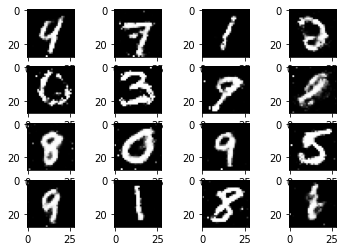

In [0]:
num_test_samples = 16
test_noise_new = Variable(torch.randn(num_test_samples, 100)).cuda()
with torch.no_grad():
        gen_images = generator(test_noise_new).cpu()
        for k in range(num_test_samples):
                    plt.subplot(4, 4, k + 1)
                    plt.imshow(gen_images[k,:].data.cpu().numpy().reshape(28, 28), cmap='Greys_r')
        plt.savefig('test.png'.format(epoch))
        plt.show()